### 1 - Simplest CNN architecture

In this simple architecture, we create a simple convolutional neural network with a convolutional layer and a pool layer. 
For the convolutional layer we want to tune the hyper parameters of out_channels and kernel_size.
To fine-tune hyperparameters we will use Ray, an open source unified framowork developed by PyTorch Fundation.
Ray Tune offers a variety of search space distributions to suit different parameter tupes: loguniform, uniform, choice, randint, grid and more.

In [100]:
import torch 
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes = 3 , out_channels = 8, conv_kernel_size = 3 , pool_kernel_size = 2):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = out_channels, kernel_size = conv_kernel_size, padding = conv_kernel_size // 2 ) # for stride = 1, conv_kernel_size // 2 seems to be the rule of thumb
        self.pool = nn.MaxPool2d(kernel_size = pool_kernel_size)
        self.fc_layer = nn.LazyLinear(num_classes) #PyTorch infers in_feature the first time it sees data, so it always matches the flatten output

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.fc_layer(x)
        return x
    




Now via the config dictionary, we will define our search space 

- tune.choice() picks one value from a finite list, all with equal probability: it is like a discrete frid over those options
- tune.loguniform(low, high): samples a continuous value between low and high, but uniformly in log space.
- tune.choice is a random search over a finite set while grid search is "try every combo in the set".

In the following code we grid search over out_channels and conv_kernel_size to study capacity vs kernel size.

Grid search fixes the architecture hyperparameters and enumerates all combinations. For each architecture, we still do a small random search over optimization hyperparameters (lr, batch_size, etc.), controlled by num_samples. We chose num_samples = 10 (or 5) to balance thoroughness and compute time.

In [101]:
from ray import tune 
import torch.optim as optim

config = {
        # Model Architecture
        "out_channels" : tune.grid_search([8,16,32]), # picked a small range that gradually increases capacity while keeping computation manageable
        "conv_kernel_size" : tune.grid_search([3,4,7]), # Small to moderately large kernels to see how much spatial context the model needs for our images
        "pool_kernel_size" : tune.choice([2, 4]), # 2 is a standard downsampling (keeps more spatial detail). 4 is more aggressive, more information loss but faster
        
        # Training Hyperparameteres:
        "lr" : tune.loguniform(0.0001, 0.1), 
        "batch_size" : tune.choice([16, 32, 64]) # Common batch sizes to balance memory and convergence speed

}

Datasets:

Training function.
Ray Tune requires a training function that accepts a configuration dictionary and runs the main training loop.
As Ray Tune runs diffrent trials, it updates the configuration dictionary for each trial.

SDG = Stochastic Gradient Descent: an optimization algorithm that updates your model's parameters by moving them a small step in the direction that reduces the loss, using a noisy estimate of the gradient computed from a mini-batch (rather than the full dataset)

In [104]:
import torch
import torch.nn as nn
import torch.optim as optim # for PyTorch optimizers
from ray import tune # to report metrics back to Ray Tune for logging the best trial
from ray.tune import Checkpoint # Ray Train checkpoint object
import tempfile
import os
import math


def train1(config, data_dir = None):
    """ Create a model instance """
    # Load datasets locally in the training function
    from torchvision import transforms, datasets # imports torchvision utilities locally inside the function - common in RayTune examples so each worker/trial can import what it needs

    img_size = (256, 256)
    train_transform = transforms.Compose([
        transforms.Resize(img_size),
        transforms.RandomHorizontalFlip(p = 0.5),
        transforms.RandomRotation(degrees= 15),
        transforms.ColorJitter(
            brightness = 0.2,
            saturation = 0.2,
            contrast = 0.2,
            hue = 0.1,
        ),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.5, 0.5, 0.5],std = [0.5,0.5,0.5])
    ])


    val_transform = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.5, 0.5, 0.5],std = [0.5,0.5,0.5])
    ])


    train_ds_local = datasets.ImageFolder("/Users/alessandro/Progetti/RockPaperScissorNew/rps-split/train", transform=train_transform)
    val_ds_local = datasets.ImageFolder("/Users/alessandro/Progetti/RockPaperScissorNew/rps-split/val", transform=val_transform)

    cnn = SimpleCNN(
        out_channels= config["out_channels"],
        conv_kernel_size = config["conv_kernel_size"] ,
        pool_kernel_size = config["pool_kernel_size"] )


    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    cnn = cnn.to(device) # moves model parameters (weights and biases) to the target device


    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(cnn.parameters(), lr = config["lr"], momentum = 0.9)

    trainloader = torch.utils.data.DataLoader(
        train_ds_local,
        batch_size = int(config["batch_size"]),
        shuffle = True,
        num_workers = 2,
    )
    valloader = torch.utils.data.DataLoader(
        val_ds_local,
        batch_size = int(config["batch_size"]),
        shuffle = False,
        num_workers = 2,
    )

    best_val_loss = math.inf

    for epoch in range(10):
        cnn.train()
        running_loss = 0.0
        n_train = 0

        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = cnn(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * labels.size(0)
            n_train += labels.size(0)

        train_loss = running_loss / max(n_train, 1)

        cnn.eval()
        val_loss = 0.0
        total = 0
        correct = 0

        with torch.no_grad():
            for inputs, labels in valloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = cnn(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * labels.size(0)
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_loss = val_loss / max(total, 1)
        val_acc = correct / max(total, 1)

        # Report metrics to Ray Tune
        report_dict = {"loss": float(val_loss), "accuracy": float(val_acc), "train_loss": float(train_loss)}

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            with tempfile.TemporaryDirectory() as checkpointdir:
                ckptpath = os.path.join(checkpointdir, "model.pt")
                torch.save({
                    "model_state": cnn.state_dict(),
                    "optimizer_state": optimizer.state_dict(),
                    "epoch": epoch,
                    "best_val_loss": best_val_loss}, ckptpath)
                checkpoint = Checkpoint.from_directory(checkpointdir)
                # pass metrics as kwargs and attach checkpoint
                tune.report(report_dict, checkpoint=checkpoint)
        else:
            tune.report(report_dict)

In [105]:
import ray
from ray import tune
from ray.tune.schedulers import ASHAScheduler # early stopping strategy that stops poorly performing trials


# Shutdown existing Ray instance if any
if ray.is_initialized():
    ray.shutdown()


# Start Ray with reduced resource allocation
ray.init(ignore_reinit_error=True, include_dashboard=False, num_cpus=6)


scheduler = ASHAScheduler(
    max_t=10,          # matches max_epochs in train1
    grace_period=1,    # minimum number of epochs a trial runs before considered for early stopping
    reduction_factor=2 # ASHAScheduler stops half of the trials at each decision point -
)


# defines settings that apply to the whole tuning run (not a single model)
run_config = tune.RunConfig(
    checkpoint_config=tune.CheckpointConfig( #we are telling Ray  how to manage checkpoints produced by the training function
        num_to_keep=1,
        checkpoint_score_attribute="loss",
        checkpoint_score_order="min",
    )
)


cpus_per_trial = 2


tuner = tune.Tuner(
    tune.with_resources(train1, resources={"cpu": cpus_per_trial}),
    tune_config=tune.TuneConfig(
        metric="loss",
        mode="min",
        scheduler=scheduler,
        num_samples=10,   # number of trials
    ),
    run_config=run_config, # attach the run level configuration
    param_space=config,    # your search space dict from the notebook
)


result_grid = tuner.fit()


best_result = result_grid.get_best_result(metric="loss", mode="min") # selects the best trial according to minimum loss from the completed results
best_config = best_result.config # extracts the hyperparameter configuration used by the best trial
best_ckpt = best_result.checkpoint


(raylet) /Users/alessandro/Progetti/RockPaperScissorNew/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
(raylet)   warnings.warn(
(train1 pid=41917) /Users/alessandro/Progetti/RockPaperScissorNew/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020 [repeated 21x across cluster]
(train1 pid=41917)   warnings.warn( [repeated 21x across cluster]
(pid=gcs_server) [2026-02-03 12:23:02,428 E 41902 3877561] (gcs_server) gcs_server.cc:302: Failed to establish connection to the event+metrics exporter agent. Events and metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc

Best config:
 {'out_channels': 16, 'conv_kernel_size': 7, 'pool_kernel_size': 2, 'lr': 0.0005115859153484923, 'batch_size': 16}
Best final metrics:
 {'loss': 0.3498551249732635, 'accuracy': 0.8987730061349694, 'train_loss': 0.3784971486054395, 'timestamp': 1770134434, 'checkpoint_dir_name': 'checkpoint_000007', 'should_checkpoint': True, 'done': True, 'training_iteration': 10, 'trial_id': 'a49fb_00050', 'date': '2026-02-03_17-00-34', 'time_this_iter_s': 29.63029670715332, 'time_total_s': 291.9411504268646, 'pid': 44042, 'hostname': 'Alessandros-MacBook-Air.local', 'node_ip': '127.0.0.1', 'config': {'out_channels': 16, 'conv_kernel_size': 7, 'pool_kernel_size': 2, 'lr': 0.0005115859153484923, 'batch_size': 16}, 'time_since_restore': 291.9411504268646, 'iterations_since_restore': 10, 'experiment_tag': '50_batch_size=16,conv_kernel_size=7,lr=0.0005,out_channels=16,pool_kernel_size=2'}


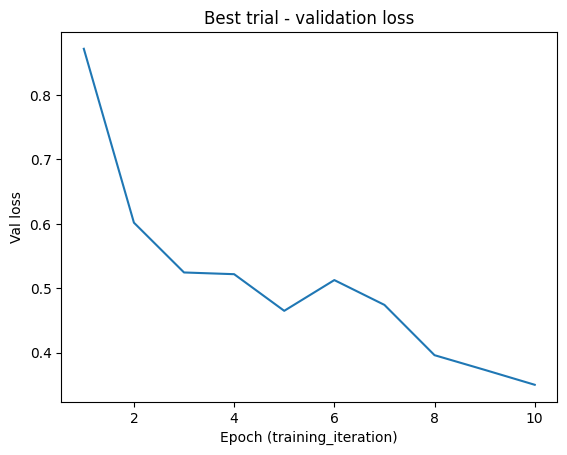

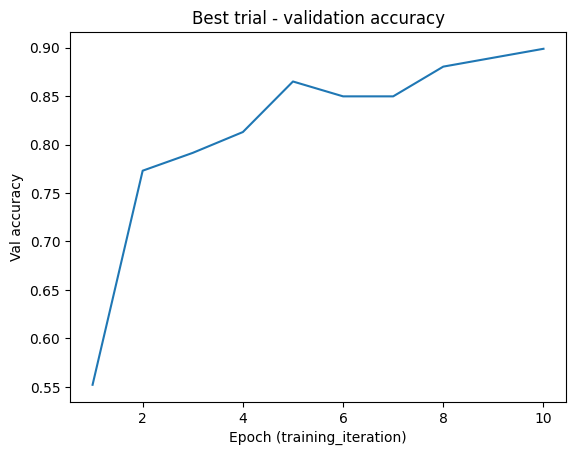

,out_channels,conv_kernel_size,pool_kernel_size,lr,batch_size,final_loss,final_accuracy
50,16,7,2,0.000512,16,0.349855,0.898773
49,16,4,4,0.001057,16,0.417078,0.880368
42,32,3,4,0.001410,16,0.421687,0.877301
44,32,7,2,0.000421,32,0.442919,0.868098
84,16,3,4,0.002255,32,0.454003,0.865031
4,16,4,2,0.001176,64,0.454366,0.871166
13,16,4,4,0.001919,64,0.457933,0.855828
87,32,3,4,0.000585,16,0.479140,0.846626
41,16,7,2,0.000283,32,0.496663,0.852761
37,8,4,2,0.000321,16,0.502697,0.852761


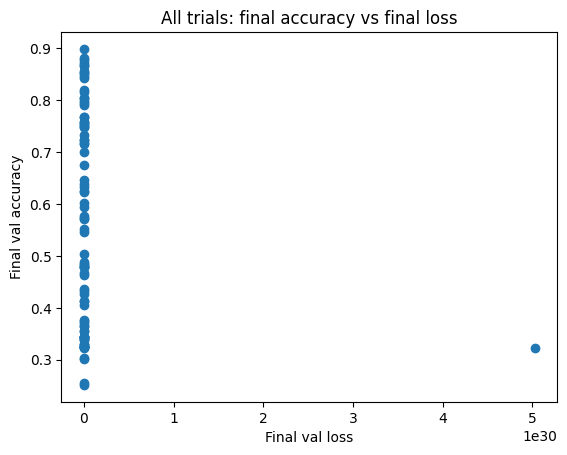

In [106]:
import pandas as pd
import matplotlib.pyplot as plt

best_result = result_grid.get_best_result(metric="loss", mode="min")
print("Best config:\n", best_result.config)
print("Best final metrics:\n", best_result.metrics)

# Per-epoch history for best trial
df_best = best_result.metrics_dataframe  # columns include: training_iteration, loss, accuracy, train_loss

plt.figure()
plt.plot(df_best["training_iteration"], df_best["loss"])
plt.xlabel("Epoch (training_iteration)")
plt.ylabel("Val loss")
plt.title("Best trial - validation loss")
plt.show()

plt.figure()
plt.plot(df_best["training_iteration"], df_best["accuracy"])
plt.xlabel("Epoch (training_iteration)")
plt.ylabel("Val accuracy")
plt.title("Best trial - validation accuracy")
plt.show()

# Summary table of final metrics across all trials
rows = []
for r in result_grid:
    rows.append({
        **r.config,
        "final_loss": r.metrics.get("loss"),
        "final_accuracy": r.metrics.get("accuracy"),
    })
df_all = pd.DataFrame(rows).sort_values("final_loss")
display(df_all.head(10))

# Scatter: accuracy vs loss
plt.figure()
plt.scatter(df_all["final_loss"], df_all["final_accuracy"])
plt.xlabel("Final val loss")
plt.ylabel("Final val accuracy")
plt.title("All trials: final accuracy vs final loss")
plt.show()

In [107]:
import os
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# 1) Paths (edit this to your test split)
TEST_DIR = "/Users/alessandro/Progetti/RockPaperScissorNew/rps-split/test"  # <-- change if needed

# 2) Device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# 3) Same preprocessing as val (resize + normalize)
img_size = (256, 256)
test_transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])

# 4) Load test set
test_ds = datasets.ImageFolder(TEST_DIR, transform=test_transform)
print("Test classes:", test_ds.classes, "  n_test:", len(test_ds))

# 5) Pick best trial + checkpoint from your existing ResultGrid
# use the ResultGrid variable from the tuning run
best_result = result_grid.get_best_result(metric="loss", mode="min")
best_config = best_result.config
best_ckpt = best_result.checkpoint

# 6) Rebuild model with best hyperparams
model = SimpleCNN(
    num_classes=len(test_ds.classes),
    out_channels=best_config["out_channels"],
    conv_kernel_size=best_config["conv_kernel_size"],
    pool_kernel_size=best_config["pool_kernel_size"],
).to(device)

# IMPORTANT: initialize LazyLinear by running a dummy forward once (because you used nn.LazyLinear)
with torch.no_grad():
    _ = model(torch.zeros(1, 3, img_size[0], img_size[1], device=device))

# 7) Load weights from checkpoint (model.pt saved inside the checkpoint directory)
ckpt_dir = best_ckpt.to_directory()
ckpt_path = os.path.join(ckpt_dir, "model.pt")

state = torch.load(ckpt_path, map_location=device)
model.load_state_dict(state["model_state"], strict=True)
model.eval()

# 8) Dataloader (you can use best batchsize or set your own)
test_loader = DataLoader(
    test_ds,
    batch_size=int(best_config["batch_size"]),
    shuffle=False,
    num_workers=2,
)

# 9) Evaluate
criterion = nn.CrossEntropyLoss()
total, correct, test_loss_sum = 0, 0, 0.0

all_preds = []
all_labels = []

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)

        bs = y.size(0)
        test_loss_sum += loss.item() * bs
        preds = logits.argmax(dim=1)

        correct += (preds == y).sum().item()
        total += bs

        all_preds.append(preds.cpu())
        all_labels.append(y.cpu())

test_loss = test_loss_sum / max(total, 1)
test_acc = correct / max(total, 1)

print("\nBest config:", best_config)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc:.4f}")

Test classes: ['paper', 'rock', 'scissors']   n_test: 331

Best config: {'out_channels': 16, 'conv_kernel_size': 7, 'pool_kernel_size': 2, 'lr': 0.0005115859153484923, 'batch_size': 16}
Test loss: 0.3869
Test accuracy: 0.8610


Confusion matrix (counts):
 [[ 87   2  19]
 [  5  89  16]
 [  4   0 109]]


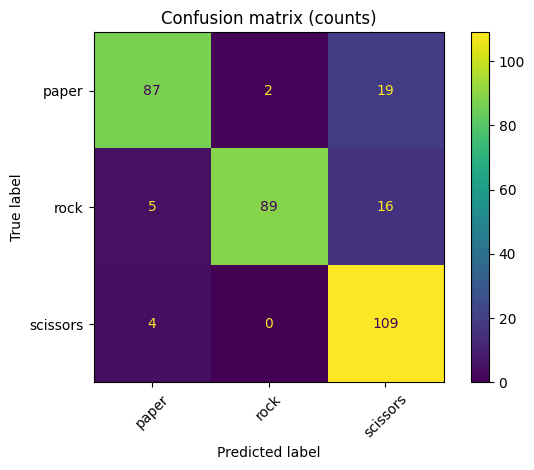

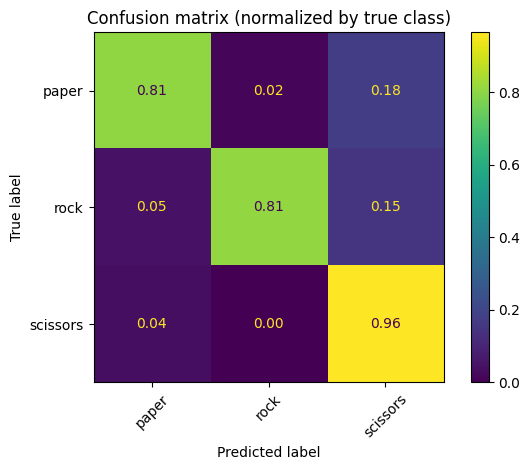


Classification report:
              precision    recall  f1-score   support

       paper     0.9062    0.8056    0.8529       108
        rock     0.9780    0.8091    0.8856       110
    scissors     0.7569    0.9646    0.8482       113

    accuracy                         0.8610       331
   macro avg     0.8804    0.8597    0.8623       331
weighted avg     0.8791    0.8610    0.8622       331



In [108]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Concatenate the tensors you collected during evaluation
y_true = torch.cat(all_labels).numpy()
y_pred = torch.cat(all_preds).numpy()

# Confusion matrix (counts)
cm = confusion_matrix(y_true, y_pred)  # C[i, j] = # true=i predicted=j [web:20]
print("Confusion matrix (counts):\n", cm)

# Optional: normalized by true class (rows sum to 1)
cm_norm = confusion_matrix(y_true, y_pred, normalize="true")  # normalize='true' -> row-normalized [web:20]

# Plot (counts)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_ds.classes)
disp.plot(xticks_rotation=45)
plt.title("Confusion matrix (counts)")
plt.tight_layout()
plt.show()  # ConfusionMatrixDisplay is intended for plotting a confusion matrix [web:27]

# Plot (row-normalized)
disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=test_ds.classes)
disp_norm.plot(xticks_rotation=45, values_format=".2f")
plt.title("Confusion matrix (normalized by true class)")
plt.tight_layout()
plt.show()  # normalize option controls how entries are normalized [web:27]

# Classification report (precision/recall/F1 per class)
print("\nClassification report:")
print(classification_report(y_true, y_pred, target_names=test_ds.classes, digits=4))  # target_names labels classes [web:19]
